# Anomaly detection

The goal of the project is to develop a method to carry out anomaly detection in IP traffic. In few words, the principle of the method is to build a profile of each IP address under the form of a small graph, called graphlet. We then build a model using Support Vector Machine to distinguish normal from malicious end hosts from an annotated trace. The last step will be to try to detect attack in a not annotated trace.

In [29]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

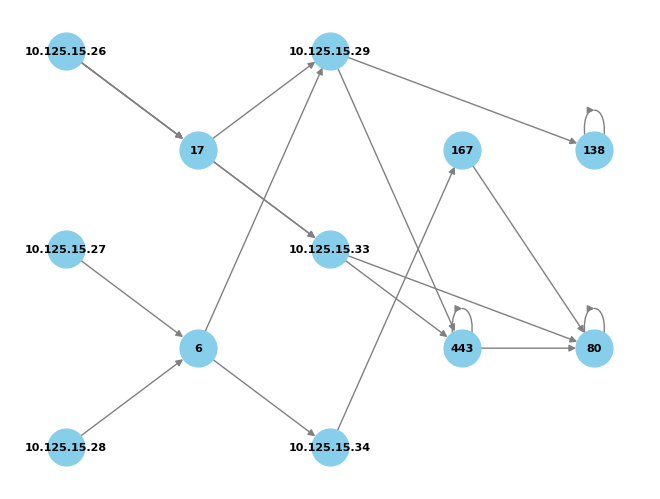

In [30]:
# 3. Build (by hand) the graphlets corresponding to the following network flows.
# format: srcIP protocol dstIP sPort dPort
def add_flow(graph, src_ip, protocol, dst_ip, src_port, dst_port):
    graph.add_node(src_ip, layer=1)
    graph.add_node(protocol, layer=2)
    graph.add_node(dst_ip, layer=3)
    graph.add_node(src_port, layer=4)
    graph.add_node(dst_port, layer=5)

    graph.add_edge(src_ip, protocol)
    graph.add_edge(protocol, dst_ip)
    graph.add_edge(dst_ip, src_port)
    graph.add_edge(src_port, dst_port)
    
G = nx.MultiDiGraph()

flows = [
    ("10.125.15.26", 17, "10.125.15.29", 138, 138),
    ("10.125.15.26", 17, "10.125.15.33", 80, 80),
    ("10.125.15.27", 6, "10.125.15.34", 167, 80),
    ("10.125.15.28", 6, "10.125.15.29", 443, 443),
    ("10.125.15.26", 17, "10.125.15.33", 443, 80),
]

for flow in flows:
    add_flow(G, *flow)

pos = nx.multipartite_layout(G, subset_key="layer")
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', font_color='black', font_size=8, edge_color='gray', arrows=True)
plt.show()

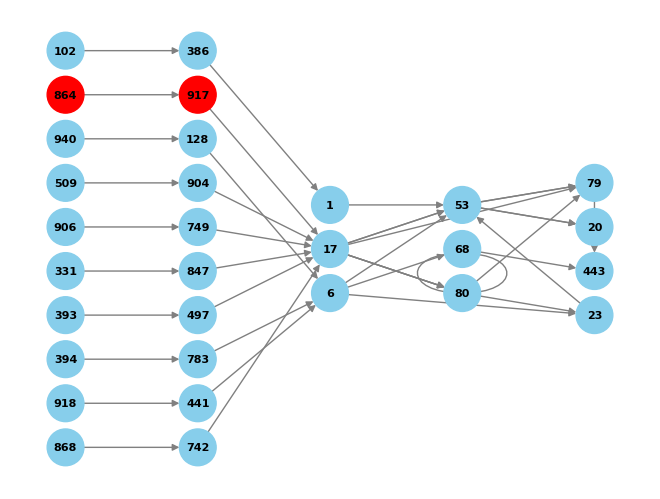

In [31]:
# 4. A traffic trace with annotated flows (normal or malicious) is provided in the file annotated-trace.txt. You will be using it to build your model of end hosts.
df_annotated = pd.read_csv("annotated-trace.csv", header=None)

def add_flow_annotated(graph, src_ip, dst_ip, protocol, src_port, dst_port, annotation):
    graph.add_node(src_ip, layer=1, annotation=annotation)
    graph.add_node(dst_ip, layer=2, annotation=annotation)
    graph.add_node(protocol, layer=3, annotation=annotation)
    graph.add_node(src_port, layer=4, annotation=annotation)
    graph.add_node(dst_port, layer=5, annotation=annotation)

    graph.add_edge(src_ip, dst_ip, annotation=annotation)
    graph.add_edge(dst_ip, protocol, annotation=annotation)
    graph.add_edge(protocol, src_port, annotation=annotation)
    graph.add_edge(src_port, dst_port, annotation=annotation)

G = nx.MultiDiGraph()

for index, row in df_annotated.head(10).iterrows():
    add_flow_annotated(G, *row)

pos = nx.multipartite_layout(G, subset_key="layer")

node_colors = ['red' if G.nodes[node].get('annotation') == 'anomaly' else 'skyblue' for node in G.nodes()]
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=700, node_color=node_colors, font_color='black', font_size=8, edge_color='gray', arrows=True)
plt.show()

Red nodes correspond to malicious flows while skyblue nodes correspond to normal flows.

In [32]:
# 5. Build all the end host graphlets corresponding to flows in annotated-trace.txt.

graphlets = []
annotations = []

for index, row in df_annotated.iterrows():
    subgraph = nx.MultiDiGraph()
    add_flow_annotated(subgraph, *row)
    graphlets.append(subgraph)
    annotations.append(row[5])

In [33]:
# 6. Build a function to transform the graphlets into the high dimensional space of the random walk kernel (consider only walks of length 4).
def increase_dimension(graphlets, length=4):
    new_graphlets = []

    for graph in graphlets:
        a = nx.adjacency_matrix(graph).toarray()
        a = np.linalg.matrix_power(a, length)
        new_graphlets.append(a)

    return new_graphlets

graphlets_l4 = increase_dimension(graphlets)

In [34]:
len(graphlets_l4), len(annotations)

(10070, 10070)

In [35]:
# reshape the graphlets sequences into an homogenous shape for the SVM model

max_rows = max(arr.shape[0] for arr in graphlets_l4)
max_cols = max(arr.shape[1] for arr in graphlets_l4)

# pad the inhomogenous sequences with -1
padded = [np.pad(arr, ((0, max_rows - arr.shape[0]), (0, max_cols - arr.shape[1])), constant_values=-1) for arr in graphlets_l4]

rwk_graphlets = np.array(padded)


In [36]:
rwk_graphlets.shape

(10070, 5, 5)

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [38]:
# 7. Use a Support Vector Machine algorithm to build a model separating the normal from the malicious end hosts in the high dimensional space.

rwk_graphlets = rwk_graphlets.reshape((rwk_graphlets.shape[0], -1))

X_rwk = np.array(rwk_graphlets)
y_rwk = np.array(annotations)

X_train_rwk, X_test_rwk, y_train_rwk, y_test_rwk = train_test_split(X_rwk, y_rwk, test_size=0.2, random_state=42)



In [39]:
svm_model = SVC(kernel='linear') 
svm_model.fit(X_train_rwk, y_train_rwk)

y_pred_rwk = svm_model.predict(X_test_rwk)

accuracy = accuracy_score(y_test_rwk, y_pred_rwk)

print("Accuracy score : ", accuracy)

Accuracy score :  0.9945382323733863


In [40]:
#8. Use now the kernel trick to avoid having to map your graphlet in the high dimensional space. Compare the computation time

# reshape the graphlets sequences into an homogenous shape for the SVM model

graphlets_seq = [nx.to_numpy_array(graphlet) for graphlet in graphlets]

max_rows = max(arr.shape[0] for arr in graphlets_seq)
max_cols = max(arr.shape[1] for arr in graphlets_seq)

# pad the inhomogenous sequences with -1
padded = [np.pad(arr, ((0, max_rows - arr.shape[0]), (0, max_cols - arr.shape[1])), constant_values=-1) for arr in graphlets_seq]

graphlets_padded = np.array(padded)


In [41]:
X_kt = graphlets_padded
y_kt = np.array(annotations)

X_kt = X_kt.reshape((X_kt.shape[0], -1))

X_train_kt, X_test_kt, y_train_kt, y_test_kt = train_test_split(X_kt, y_kt, test_size=0.2, random_state=42)


In [42]:
svm_model_kernel_trick = SVC(kernel='rbf')  
svm_model_kernel_trick.fit(X_train_kt, y_train_kt)

y_pred_kt = svm_model_kernel_trick.predict(X_test_kt)

accuracy = accuracy_score(y_test_kt, y_pred_kt)

print(f"Accuracy (Kernel Trick): {accuracy}")

Accuracy (Kernel Trick): 0.9945382323733863


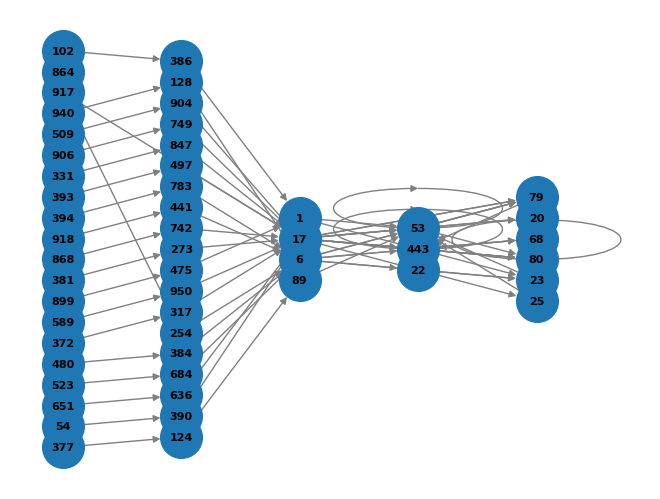

In [43]:
# 9. Apply your model to the traffic trace provided in the file not-annotated-trace.txt.
# Do you detect anomalous traffic? Plot them. To which kind of attacks,
# could they correspond?

df_not_annotated = pd.read_csv("not-annotated-trace.csv", header=None)

def add_flow_not_annotated(graph, src_ip, dst_ip, protocol, src_port, dst_port):
    graph.add_node(src_ip, layer=1)
    graph.add_node(dst_ip, layer=2)
    graph.add_node(protocol, layer=3)
    graph.add_node(src_port, layer=4)
    graph.add_node(dst_port, layer=5)

    graph.add_edge(src_ip, dst_ip)
    graph.add_edge(dst_ip, protocol)
    graph.add_edge(protocol, src_port)
    graph.add_edge(src_port, dst_port)

for index, row in df_not_annotated.head(10).iterrows():
    add_flow_not_annotated(G, *row)

pos = nx.multipartite_layout(G, subset_key="layer")

nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=900, font_color='black', font_size=8, edge_color='gray', arrows=True)
plt.show()

In [44]:
# build all the end host graphlets corresponding to flows in not-annotated-trace.txt.

graphlets_not_annotated = []

for index, row in df_not_annotated.iterrows():
    subgraph = nx.MultiDiGraph()
    add_flow_not_annotated(subgraph, *row)
    graphlets_not_annotated.append(subgraph)

# pad the graphlets in order to bring them an homogenous shape
    
graphlets_seq_na = [nx.to_numpy_array(graphlet) for graphlet in graphlets_not_annotated]

max_rows = max(arr.shape[0] for arr in graphlets_seq_na)
max_cols = max(arr.shape[1] for arr in graphlets_seq_na)

# pad the inhomogenous sequences with -1
padded = [np.pad(arr, ((0, max_rows - arr.shape[0]), (0, max_cols - arr.shape[1])), constant_values=-1) for arr in graphlets_seq_na]

graphlets_padded_na = np.array(padded)

X_not_annotated_kt = np.array(graphlets_padded_na)

# flatten the sequences for the SVM 

X_not_annotated_kt = X_not_annotated_kt.reshape((X_not_annotated_kt.shape[0], -1))

predictions = svm_model_kernel_trick.predict(X_not_annotated_kt)

print(predictions)

print("Anomalous Traffic Detected:")
for i, prediction in enumerate(predictions):
    if prediction != 'normal':  
        print(f"Anomaly detected in flow {i + 1}")


['normal' 'normal' 'normal' ... 'normal' 'normal' 'normal']
Anomalous Traffic Detected:


In [45]:
'''# Plot the graphs with annotations based on predictions
for i, graph_not_annotated in enumerate(graphlets_not_annotated):
    prediction_label = "Anomaly" if predictions[i] == 1 else "Normal"
    plt.figure(figsize=(8, 8))
    plt.title(f"Flow {i + 1} - Prediction: {prediction_label}")
    
    pos = nx.spring_layout(graph_not_annotated)
    nx.draw(graph_not_annotated, pos, with_labels=True, font_weight='bold', node_color='skyblue', node_size=800, edge_color='gray')
    
    plt.show()
    '''


'# Plot the graphs with annotations based on predictions\nfor i, graph_not_annotated in enumerate(graphlets_not_annotated):\n    prediction_label = "Anomaly" if predictions[i] == 1 else "Normal"\n    plt.figure(figsize=(8, 8))\n    plt.title(f"Flow {i + 1} - Prediction: {prediction_label}")\n    \n    pos = nx.spring_layout(graph_not_annotated)\n    nx.draw(graph_not_annotated, pos, with_labels=True, font_weight=\'bold\', node_color=\'skyblue\', node_size=800, edge_color=\'gray\')\n    \n    plt.show()\n    '

**Predicting anomalies with Data augmentation**

To try to overcome the issue of the lack of anomaly data (therefore, our model does not learn well), we proceed by data augmentation. To do this, we will use oversampling method by imblearn library.

In [63]:
## oversampling version
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0, sampling_strategy=0.2)
X_resampled_rwk, y_resampled_rwk = ros.fit_resample(X_rwk, y_rwk)

We now check the flow distribution over the newly upsampled dataset

In [64]:
anomalies = (np.sum(y_resampled_rwk == 'anomaly') / len(y_resampled_rwk)) * 100
print("Percentage of anormal flows : ", anomalies)


Percentage of anormal flows :  16.666666666666664


In [65]:
X_train_rwk, X_test_rwk, y_train_rwk, y_test_rwk = train_test_split(X_resampled_rwk, y_resampled_rwk, test_size=0.2, random_state=42)

We proceed now to re-training the SVM model. first, with the high dimensional space transformation

In [66]:
svm_model = SVC(kernel='linear') 
svm_model.fit(X_train_rwk, y_train_rwk)

y_pred_rwk = svm_model.predict(X_test_rwk)

accuracy = accuracy_score(y_test_rwk, y_pred_rwk)

print("Accuracy score : ", accuracy)

Accuracy score :  0.83


Now, we upsample the graphlets once again and then re-train the SVM model using the kernel trick

In [67]:
## oversampling version
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0, sampling_strategy=0.2)
X_resampled_kt, y_resampled_kt = ros.fit_resample(X_kt, y_kt)

In [68]:
X_train_kt, X_test_kt, y_train_kt, y_test_kt = train_test_split(X_resampled_kt, y_resampled_kt, test_size=0.2, random_state=42)

In [69]:
svm_model_kernel_trick = SVC(kernel='rbf')  
svm_model_kernel_trick.fit(X_train_kt, y_train_kt)

y_pred_kt = svm_model_kernel_trick.predict(X_test_kt)

accuracy = accuracy_score(y_test_kt, y_pred_kt)

print(f"Accuracy (Kernel Trick): {accuracy}")

Accuracy (Kernel Trick): 0.83


We can observe now that both of the classification methods give the same accuracy results. 
The first method is twice faster than the method using the kernel trick with an execution of 16.0s contrary to a computation time of 28.2s.

We proceed to predictions. For this, we will build the end host models using the random walk kernel with transforming the graphlets into the high dimensional space of the random walk kernel, as this method has shown the fastest computation time

In [70]:
# transform the graphlets into the high dimensional space of the random walk kernel (consider only walks of length 4).
graphlets_l4_not_annotated = increase_dimension(graphlets_not_annotated)

In [71]:
# reshape the graphlets sequences into an homogenous shape for the SVM model

max_rows = max(arr.shape[0] for arr in graphlets_l4_not_annotated)
max_cols = max(arr.shape[1] for arr in graphlets_l4_not_annotated)

# pad the inhomogenous sequences with -1
padded = [np.pad(arr, ((0, max_rows - arr.shape[0]), (0, max_cols - arr.shape[1])), constant_values=-1) for arr in graphlets_l4_not_annotated]

rwk_graphlets_not_annotated = np.array(padded)

In [72]:
X_not_annotated_rwk = np.array(rwk_graphlets_not_annotated)

# flatten the sequences for the SVM 

X_not_annotated_rwk = X_not_annotated_rwk.reshape((X_not_annotated_rwk.shape[0], -1))

predictions = svm_model.predict(X_not_annotated_rwk)

print(predictions)

print("Anomalous Traffic Detected:")
for i, prediction in enumerate(predictions):
    if prediction != 'normal':  
        print(f"Anomaly detected in flow {i + 1}")

['normal' 'normal' 'normal' ... 'normal' 'normal' 'normal']
Anomalous Traffic Detected:
Anomaly detected in flow 998
Anomaly detected in flow 1628
Anomaly detected in flow 1644
Anomaly detected in flow 1719
Anomaly detected in flow 2036
Anomaly detected in flow 2306
Anomaly detected in flow 2469
Anomaly detected in flow 5250
Anomaly detected in flow 6695
Anomaly detected in flow 7299
Anomaly detected in flow 8375


In [73]:
anomalies = (np.sum(predictions == 'anomaly') / len(predictions)) * 100
print("Percentage of anormal flows predicted : ", anomalies)

Percentage of anormal flows predicted :  0.10923535253227407


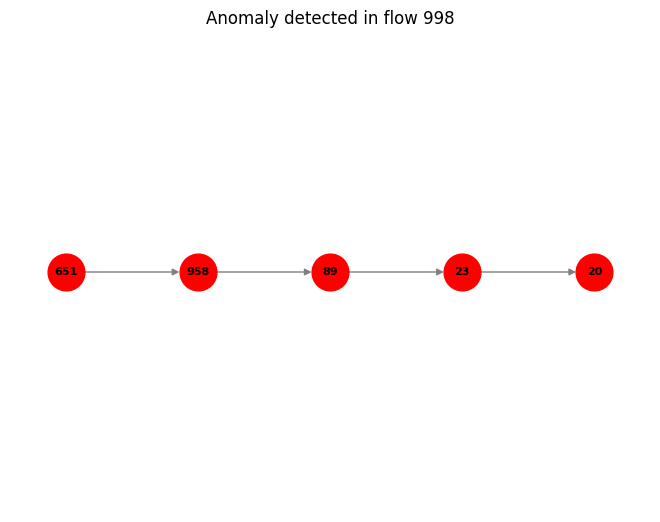

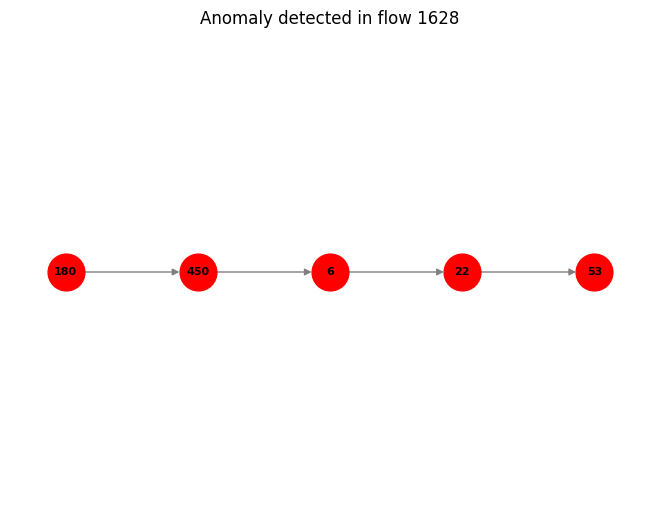

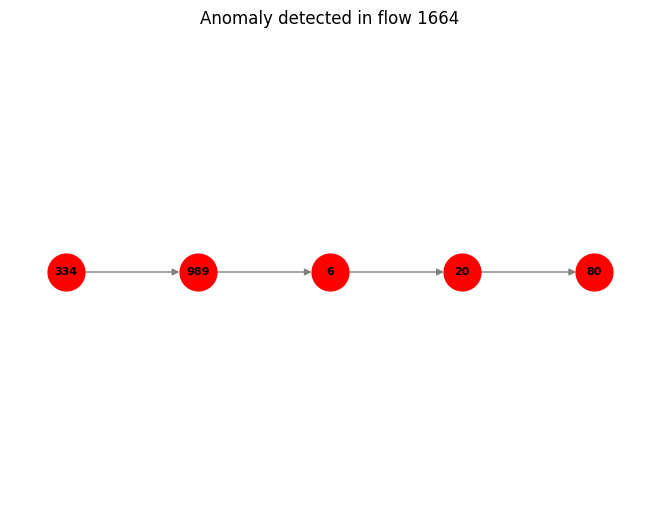

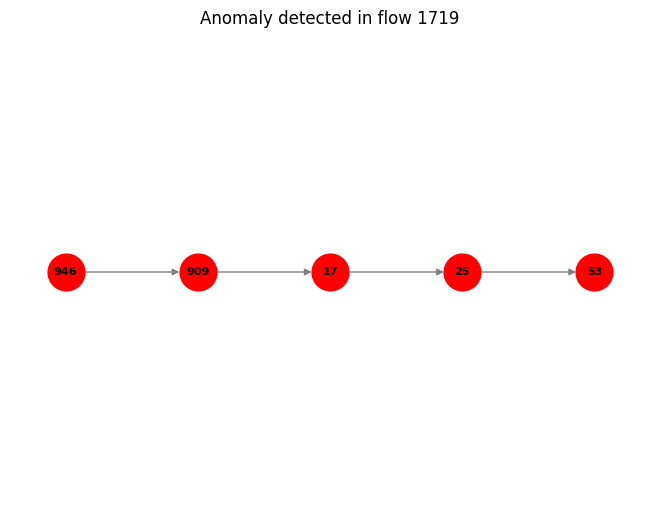

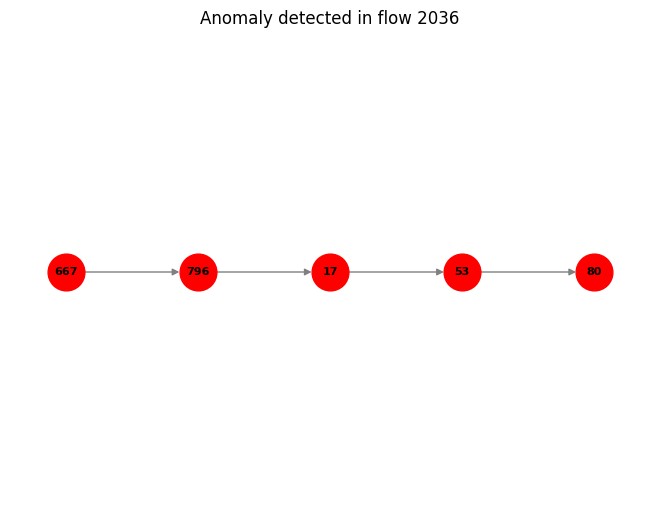

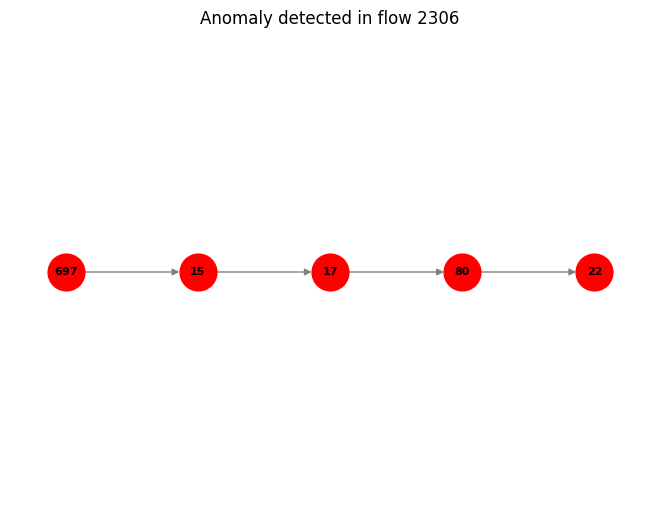

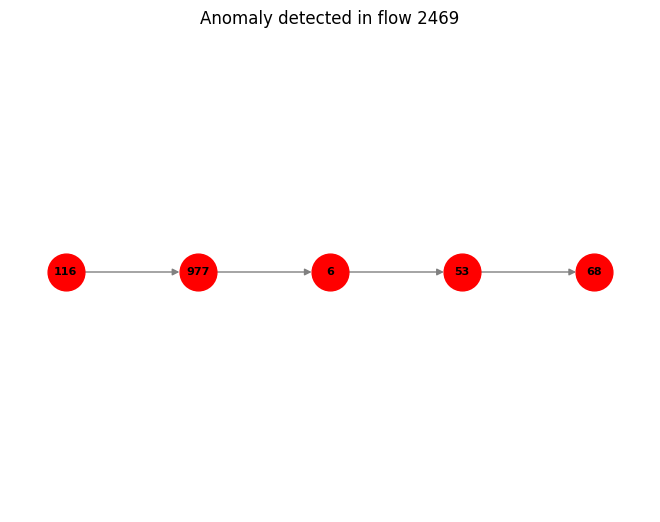

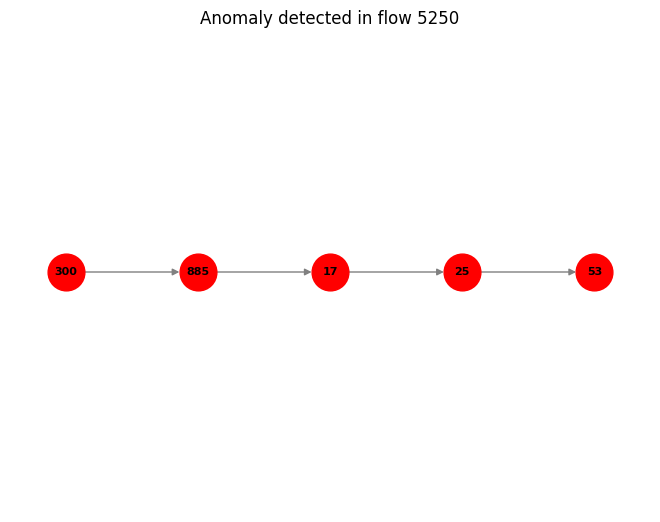

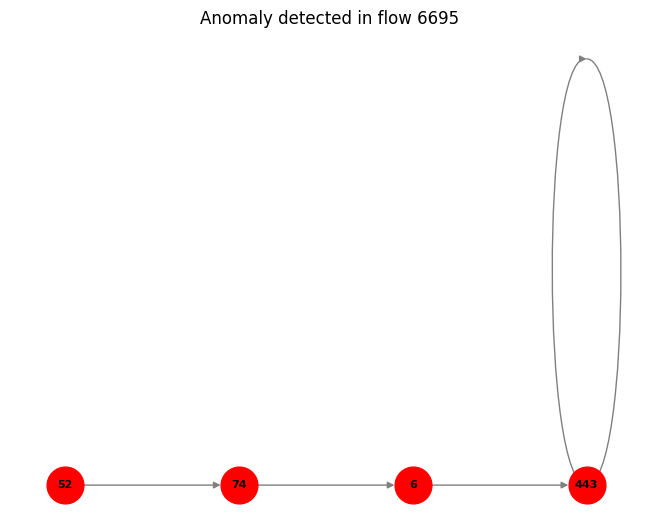

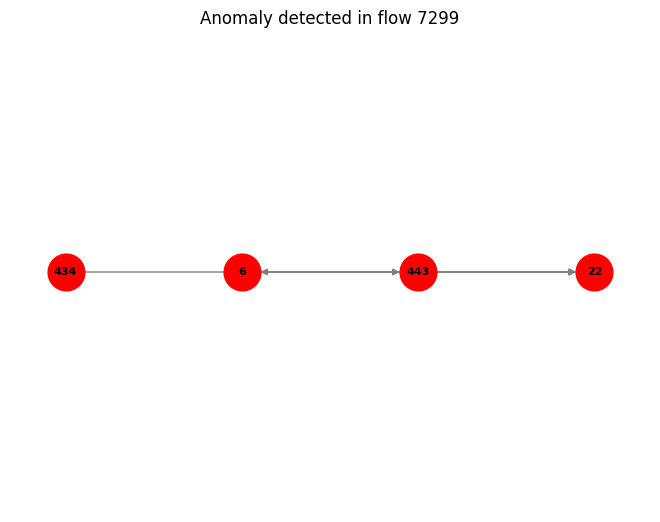

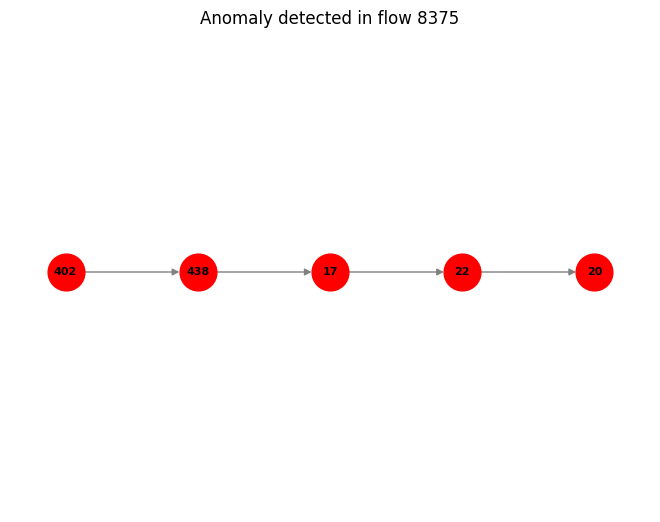

In [80]:
for anomaly_id in [998, 1628, 1664, 1719, 2036, 2306, 2469, 5250, 6695, 7299, 8375]:
    anomaly_graph = nx.MultiDiGraph()
    add_flow_not_annotated(anomaly_graph, df_annotated.iloc[anomaly_id, 0],df_annotated.iloc[anomaly_id, 1], df_annotated.iloc[anomaly_id, 2], df_annotated.iloc[anomaly_id, 3], df_annotated.iloc[anomaly_id, 4] )
    pos_anomaly = nx.multipartite_layout(anomaly_graph, subset_key="layer")
    nx.draw(anomaly_graph, pos_anomaly, with_labels=True, font_weight='bold', 
            node_size=700, node_color='red', font_color='black', font_size=8, edge_color='gray', arrows=True)
    plt.title(f'Anomaly detected in flow {anomaly_id}')
    plt.show()